Test the application of these files by first: 
1. Building a sample dataset to test with 
2. Running through each function and plotting the results


In [1]:
# Source the GDAL_quickTricks.py file

%run GDAL_quickTricks.py

# Now you can use the functions defined in GDAL_quickTricks.py

## Creating test data 
### Test Rasters 

In [2]:
# Set the save directory to the same location as the code file
save_dir = os.path.dirname(os.path.abspath("C:/Users/ssmithtr/Desktop/Sync/Workoffline/New folder/Test_R/ "))

# Create a 100x100 raster with 10 bands
driver = gdal.GetDriverByName('GTiff')
raster_100x100_10bands = driver.Create(os.path.join(save_dir,
                                                     'raster_100x100_10bands.tif'),
                                                       10000, 10000, 10, gdal.GDT_Float32)

# Set geotransform and projection
geotransform = [0, 1, 0, 0, 0, -1]
raster_100x100_10bands.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
raster_100x100_10bands.SetProjection(srs.ExportToWkt())

# Write random data to each band
for i in range(1, 11):
    data = np.random.rand(10000, 10000).astype(np.float32)
    raster_100x100_10bands.GetRasterBand(i).WriteArray(data)

raster_100x100_10bands = None

# Create a 250x250 raster
raster_250x250 = driver.Create(os.path.join(save_dir, 'raster_250x250.tif'), 
                               25000, 25000, 1, gdal.GDT_Float32)
# Set geotransform and projection
geotransform = [50, 1, 0, 50, 0, -1]  # Offset by 50 units
raster_250x250.SetGeoTransform(geotransform)
raster_250x250.SetProjection(srs.ExportToWkt())

# Write random data to the band
data = np.random.rand(25000, 25000).astype(np.float32)
raster_250x250.GetRasterBand(1).WriteArray(data)

raster_250x250 = None
print('test rasters created')

test rasters created


### Create a Test Shapefile

In [3]:

# Assuming raster_extent is already defined from the previous code block
raster_extent = [
    0,  # geotransform[0]
    0 + 1 * 10000 * 0.5,  # geotransform[0] + geotransform[1] * raster_100x100_10bands.RasterXSize * 0.5
    0 + (-1) * 10000 * 0.5,  # geotransform[3] + geotransform[5] * raster_100x100_10bands.RasterYSize * 0.5
    0  # geotransform[3]
]

# Create a shapefile
driver = ogr.GetDriverByName('ESRI Shapefile')
shapefile = driver.CreateDataSource(os.path.join(save_dir, 'clip_shapefile.shp'))
layer = shapefile.CreateLayer('layer', geom_type=ogr.wkbPolygon)

# Create a field
field = ogr.FieldDefn('id', ogr.OFTInteger)
layer.CreateField(field)

# Create a polygon geometry that is half the size of the raster
half_width = (raster_extent[1] - raster_extent[0])
half_height = (raster_extent[3] - raster_extent[2])

ring = ogr.Geometry(ogr.wkbLinearRing)
ring.AddPoint(raster_extent[0], raster_extent[3])  # Bottom-left
ring.AddPoint(raster_extent[0], raster_extent[3] - half_height)  # Top-left
ring.AddPoint(raster_extent[0] + half_width, raster_extent[3] - half_height)  # Top-right
ring.AddPoint(raster_extent[0] + half_width, raster_extent[3])  # Bottom-right
ring.AddPoint(raster_extent[0], raster_extent[3])  # Closing the ring

polygon = ogr.Geometry(ogr.wkbPolygon)
polygon.AddGeometry(ring)

# Create a feature and set the geometry and attribute
feature_defn = layer.GetLayerDefn()
feature = ogr.Feature(feature_defn)
feature.SetGeometry(polygon)
feature.SetField('id', 1)
layer.CreateFeature(feature)

# Cleanup
feature = None
shapefile = None

print(f"Shapefile created at: {os.path.join(save_dir, 'clip_shapefile.shp')}")

Shapefile created at: C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\clip_shapefile.shp


## Visualize the Rasters 

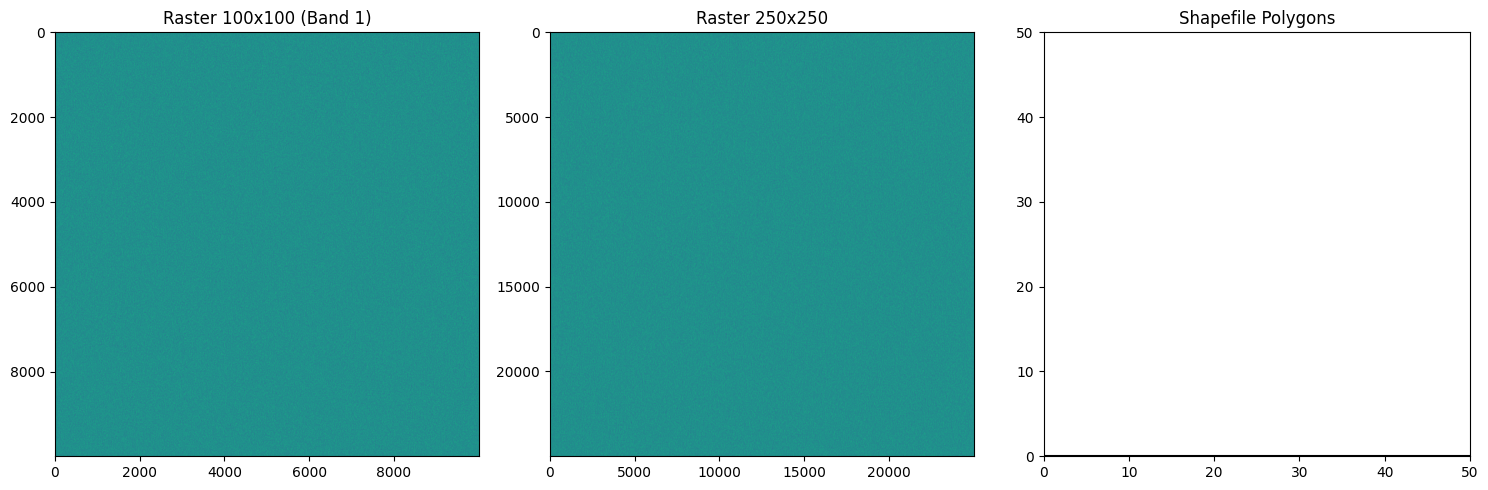

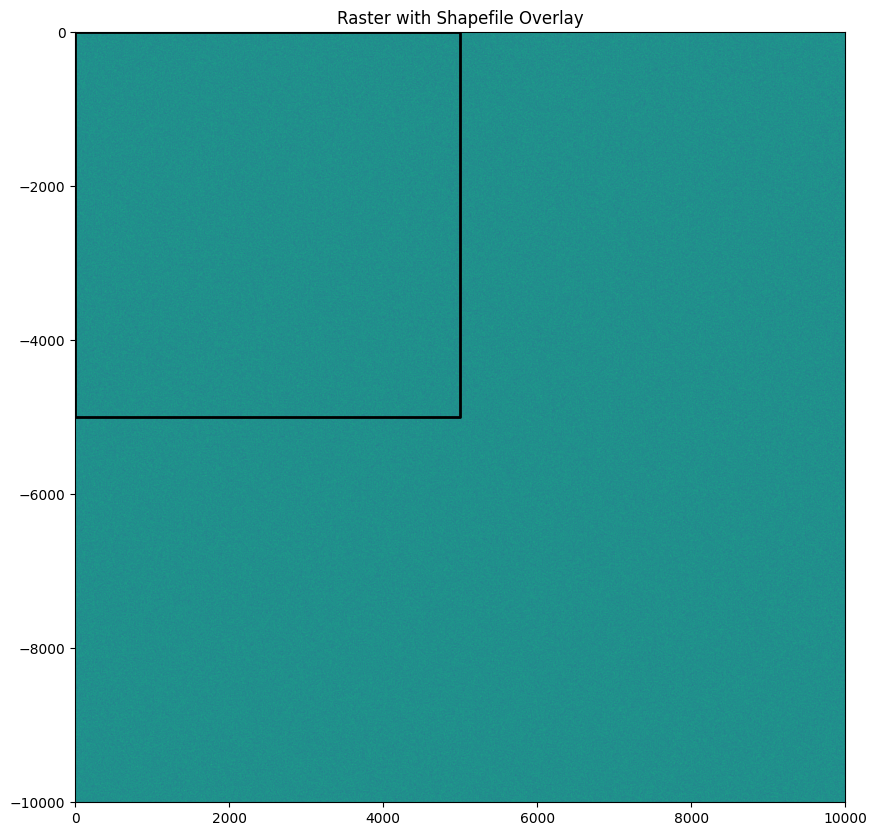

In [4]:
import matplotlib.pyplot as plt

# Read the first raster
raster_100x100_10bands_path = os.path.join(save_dir, 'raster_100x100_10bands.tif')
raster_100x100_10bands = gdal.Open(raster_100x100_10bands_path)
raster_100x100_10bands_data = raster_100x100_10bands.GetRasterBand(1).ReadAsArray()

# Read the second raster
raster_250x250_path = os.path.join(save_dir, 'raster_250x250.tif')
raster_250x250 = gdal.Open(raster_250x250_path)
raster_250x250_data = raster_250x250.GetRasterBand(1).ReadAsArray()

# Read the shapefile
shapefile_path = os.path.join(save_dir, 'clip_shapefile.shp')
driver = ogr.GetDriverByName('ESRI Shapefile')
datasource = driver.Open(shapefile_path, 0)
layer = datasource.GetLayer()
polygons = []
for feature in layer:
    geom = feature.GetGeometryRef()
    polygons.append(geom.Clone())

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first raster (first band)
axes[0].imshow(raster_100x100_10bands_data, cmap='viridis')
axes[0].set_title('Raster 100x100 (Band 1)')

# Plot the second raster
axes[1].imshow(raster_250x250_data, cmap='viridis')
axes[1].set_title('Raster 250x250')

# Plot the shapefile polygons
for polygon in polygons:
    x = [point[0] for point in polygon.GetGeometryRef(0).GetPoints()]
    y = [point[1] for point in polygon.GetGeometryRef(0).GetPoints()]
    axes[2].plot(x, y, 'k-')
axes[2].set_title('Shapefile Polygons')
axes[2].set_xlim(0, 50)
axes[2].set_ylim(0, 50)

plt.tight_layout()
plt.show()

# Read the raster
raster_path = os.path.join(save_dir, 'raster_100x100_10bands.tif')
raster = gdal.Open(raster_path)
raster_data = raster.GetRasterBand(1).ReadAsArray()
geotransform = raster.GetGeoTransform()

# Read the shapefile
shapefile_path = os.path.join(save_dir, 'clip_shapefile.shp')
driver = ogr.GetDriverByName('ESRI Shapefile')
datasource = driver.Open(shapefile_path, 0)
layer = datasource.GetLayer()

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster
raster_extent = [
    geotransform[0],
    geotransform[0] + geotransform[1] * raster.RasterXSize,
    geotransform[3] + geotransform[5] * raster.RasterYSize,
    geotransform[3]
]
ax.imshow(raster_data, extent=raster_extent, cmap='viridis')

# Plot the shapefile polygons
for feature in layer:
    geom = feature.GetGeometryRef()
    ring = geom.GetGeometryRef(0)
    x = [ring.GetPoint(i)[0] for i in range(ring.GetPointCount())]
    y = [ring.GetPoint(i)[1] for i in range(ring.GetPointCount())]
    ax.plot(x, y, 'k-', linewidth=2)

ax.set_title('Raster with Shapefile Overlay')
plt.show()

## Stack the raster so that it has many layers (years or bands etc )

In [5]:
# Read the first raster
raster_100x100_10bands_path = os.path.join(save_dir, 'raster_100x100_10bands.tif')

# Create a subfolder named 'bands' if it doesn't exist
bands_dir = os.path.join(save_dir, 'bands')
os.makedirs(bands_dir, exist_ok=True)

# Write out each band individually
for band_index in range(1, raster_100x100_10bands.RasterCount + 1):
    band_data = raster_100x100_10bands.GetRasterBand(band_index).ReadAsArray()
    
    # Create a new raster dataset for each band
    driver = gdal.GetDriverByName('GTiff')
    band_path = os.path.join(bands_dir, f'band_{band_index}.tif')
    out_raster = driver.Create(band_path, raster_100x100_10bands.RasterXSize, raster_100x100_10bands.RasterYSize, 1, gdal.GDT_Float32)
    
    # Set the geotransform and projection from the original raster
    out_raster.SetGeoTransform(raster_100x100_10bands.GetGeoTransform())
    out_raster.SetProjection(raster_100x100_10bands.GetProjection())
    
    # Write the band data to the new raster
    out_raster.GetRasterBand(1).WriteArray(band_data)
    
    # Flush and close the dataset
    out_raster.FlushCache()
    out_raster = None

print("Bands have been written out individually.")

Bands have been written out individually.


## Test Quick Crop

C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\clip_shapefile.shp
Iter time: 14.439344644546509
Output file: C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\cropped_rasters.tif


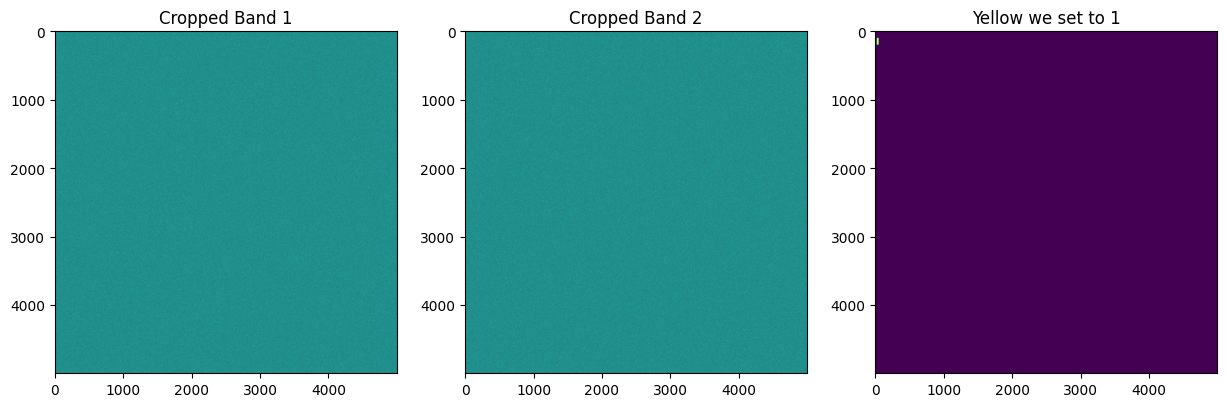

Rasters have been cropped to the shapefile.


In [6]:
## test the crop to cutline on the band stack 
rasters = bands_dir
shapefile = shapefile_path
print(shapefile_path)
output_file = os.path.join(save_dir, 'cropped_rasters')
quick_clip(rasters, shapefile, output_file)
## open th output file and plot it
import matplotlib.pyplot as plt
r = gdal.Open(output_file + ".tif")
r1 = r.GetRasterBand(1).ReadAsArray()
r2 = r.GetRasterBand(2).ReadAsArray()
diffr = np.where(r1 == r2, 1, 0)
diffr[100:200, 25:55] = 1

# Plotting both and show they are still different 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first raster (first band)
axes[0].imshow(r.GetRasterBand(1).ReadAsArray(), cmap='viridis')
axes[0].set_title('Cropped Band 1')

# Plot the second raster
axes[1].imshow(r.GetRasterBand(2).ReadAsArray(), cmap='viridis')
axes[1].set_title('Cropped Band 2')
# Plot the second raster
axes[2].imshow(diffr, cmap='viridis')
axes[2].set_title('Yellow we set to 1')
plt.show()
print("Rasters have been cropped to the shapefile.")

## Test Mosaic Function
### First - put a whole in the middle of one of the rasters 
### Then mosaic, use the NA to show you have the first value 

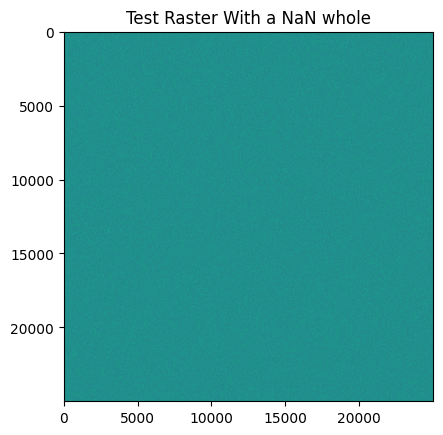

In [7]:
## in the middle of the 250x250 raster put a NA hole of size 10 x 10
r = gdal.Open(raster_250x250_path)
band = r.GetRasterBand(1)
data = band.ReadAsArray()
data[600:900,0:70] = np.nan
plt.imshow(data, cmap='viridis')
plt.title("Test Raster With a NaN whole")
## write the data back to the raster
driver = gdal.GetDriverByName('GTiff')
output_path = os.path.join(save_dir, 'raster_250x250_with_hole.tif')
out_raster = driver.Create(output_path, r.RasterXSize, r.RasterYSize, 1, gdal.GDT_Float32)
out_raster.SetGeoTransform(r.GetGeoTransform())
out_raster.SetProjection(r.GetProjection())
out_raster.GetRasterBand(1).WriteArray(data)
out_raster.FlushCache()
out_raster = None

C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\mosaic_rasters


Iter time: 20.40843963623047
Output file: C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\mosaic_rasters.tif


Text(0.5, 1.0, 'The NaN whole was filled b/c the rasters overlapped')

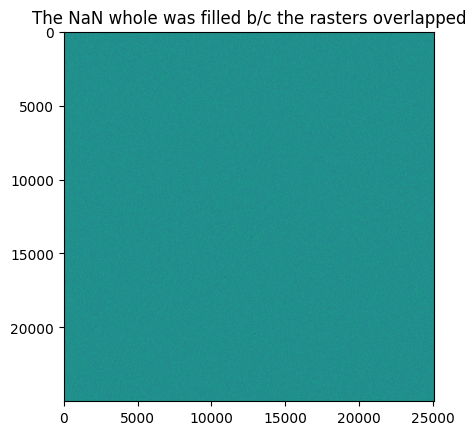

In [8]:
## test the mosaic function on the two raster 
raster_paths = [output_path,r'C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\bands\band_1.tif']
output_path2 = os.path.join(save_dir, 'mosaic_rasters')
print(output_path2)
quick_mosaic(raster_paths, output_path2)
## open the output file and plot it
import matplotlib.pyplot as plt
r = gdal.Open(output_path2 + ".tif")

r1 = r.GetRasterBand(1).ReadAsArray()
## get that they the NA are ignored 
plt.imshow(r1)
plt.title("The NaN whole was filled b/c the rasters overlapped")

Test the translating function

In [9]:
## test the mosaic function on the two raster 
raster_paths = r'C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\bands\band_1.tif'
output_path3 = os.path.join(save_dir, 'reprojected_raster.tif')
quick_translate(raster_paths, output_path2, "EPSG:4326")

Iter time: 10.731093406677246
Raster has been reprojected and saved to:  C:\Users\ssmithtr\Desktop\Sync\Workoffline\New folder\Test_R\mosaic_rasters
